# **Set according to environment (e.g. local, Google Colab...)**

In [1]:
project_folder = ''

# **Body**

In [2]:
from custom_libraries.miscellaneous import progress_bar
from custom_libraries.image_dataset import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
bs = 256
weighting = 'paired'
trials = 10
classes = 10

ds_set = ['mnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']

#paired_test = np.zeros((len(ds_set), trials, classes, classes))

paired_test = np.load(project_folder + 'results/confused_pairs_all.npy', allow_pickle=True)
#heatmap_matrix = np.load()

for k, ds in enumerate(ds_set):

    print(f"- Dataset: {ds}")
    test_ds = ImageDataset(ds, 'test', data_dir=None, USPS_dir=project_folder+'USPS/')
    train_ds = ImageDataset(ds, 'train', data_dir=None, USPS_dir=project_folder+'USPS/')

    for x in [train_ds, test_ds]:
        x.shuffle()
        x.normalize()
        if x.images.shape[1:3] == (28, 28):
            x.pad()
        x.vectorize(True)

    for t1 in range(10):
        for t2 in range(t1 + 1, 10):

            if paired_test[k, -1, t1, t2] != 0:
                continue

            finished = False

            while not finished:

              try:

                progress_bar(0, max = 10, pre = f"-- Pair {t1} - {t2}:\t")
                train_ds.shuffle()
                test_ds.shuffle()
                X_test, y_test = test_ds.filter(t1, t2)
                X_train, y_train = train_ds.filter(t1, t2)
                # Per coerenza con Jones&Kording
                train_len = len(X_train)-len(X_test)
                X_train, y_train = [X_train[i] for i in range(train_len)], [y_train[i] for i in range(train_len)]

                X_train = np.array_split(X_train, trials)
                y_train = np.array_split(y_train, trials)

                average_acc = 0

                for m in range(trials):

                    lda = LinearDiscriminantAnalysis()
                    lda.fit(X_train[m], y_train[m])
                    score_test = lda.score(X_test, y_test)

                    paired_test[k, m, t1, t2] = score_test
                    average_acc = average_acc + score_test

                    progress_bar(m+1, max = 10, pre = f"-- Pair {t1} - {t2}:\t")

                progress_bar(10, max = 10, pre = f"-- Pair {t1} - {t2}:\t", post = f"\tAccuracy = {average_acc / trials}")
                print()

                np.save(project_folder + 'results/confused_pairs_all.npy', paired_test)

                finished = True

              except:

                print("\nAn error occurred. Repeating the pair.")

- Dataset: mnist
- Dataset: fmnist
- Dataset: kmnist
- Dataset: svhn
-- Pair 4 - 6:	[====================] 100%	Accuracy = 0.5316888888888889
-- Pair 4 - 7:	[====================] 100%	Accuracy = 0.5300968736239542
-- Pair 4 - 8:	[====================] 100%	Accuracy = 0.5489839827874732
-- Pair 4 - 9:	[====================] 100%	Accuracy = 0.5451432734337056
-- Pair 5 - 6:	[====================] 100%	Accuracy = 0.5186425131850492
-- Pair 5 - 7:	[====================] 100%	Accuracy = 0.5214626391096979
-- Pair 5 - 8:	[====================] 100%	Accuracy = 0.5266815034619189
-- Pair 5 - 9:	[====================] 100%	Accuracy = 0.537547122392561
-- Pair 6 - 7:	[====================] 100%	Accuracy = 0.5252752752752753
-- Pair 6 - 8:	[====================] 100%	Accuracy = 0.5180368435523783
-- Pair 6 - 9:	[====================] 100%	Accuracy = 0.5264557670772676
-- Pair 7 - 8:	[====================] 100%	Accuracy = 0.5316662136450121
-- Pair 7 - 9:	[====================] 100%	Accuracy = 0.

RESULTS:


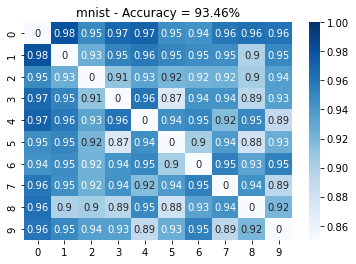

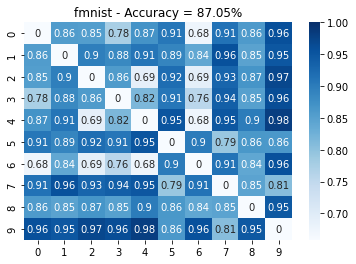

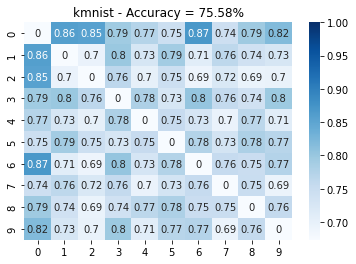

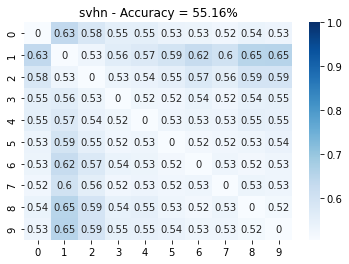

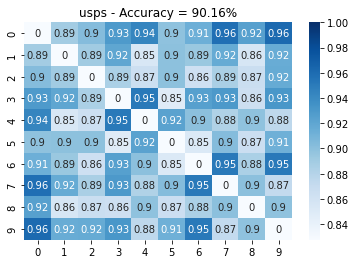

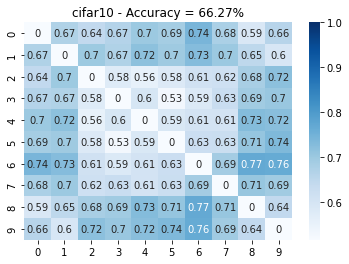

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ds_set = ['mnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']
paired_test = np.load(project_folder+'results/confused_pairs_all.npy', allow_pickle=True)

print("RESULTS:")
for k, ds in enumerate(ds_set):
    num_classes = len(paired_test[k, 0])
    heatmap_matrix = np.zeros((num_classes, num_classes))
    for t1 in range(num_classes):
        for t2 in range(t1+1, num_classes):
            heatmap_matrix[t1, t2] = np.mean(paired_test[k, :, t1, t2])
            heatmap_matrix[t2, t1] = heatmap_matrix[t1, t2]

    min_acc = .975 * min(heatmap_matrix[np.nonzero(heatmap_matrix)])
    plt.figure()
    ax = sns.heatmap(heatmap_matrix, annot=True, cmap='Blues', vmin=min_acc, vmax=1)
    ax.set_title(ds + f" - Accuracy = {round(np.mean(heatmap_matrix[np.nonzero(heatmap_matrix)]) * 100, 2)}%")